In [1]:
import numpy as np
import glob
import random
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import *

## 1. Download Data

[Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/)

In [2]:
# download the Penn-Fudan dataset
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
!unzip PennFudanPed.zip

--2021-04-26 14:37:19--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip.1’

PennFudanPed.zip.1  100%[===================>]  51.23M  85.5MB/s    in 0.6s    

2021-04-26 14:37:20 (85.5 MB/s) - ‘PennFudanPed.zip.1’ saved [53723336/53723336]

--2021-04-26 14:37:20--  http://./
Resolving .... failed: Name or service not known.
wget: unable to resolve host address ‘.’
FINISHED --2021-04-26 14:37:20--
Total wall clock time: 0.7s
Downloaded: 1 files, 51M in 0.6s (85.5 MB/s)
Archive:  PennFudanPed.zip
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## 2. Looking at Examples 

Lets look at a random Image and its corresponding Mask

/opt/apps/anaconda3/envs/wmlce-v1.7.0-py3.7/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(-0.5, 489.5, 377.5, -0.5)

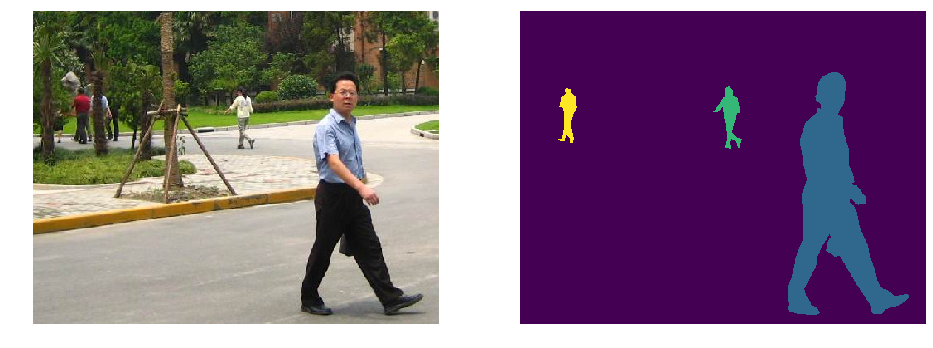

In [3]:
img_path = 'PennFudanPed/PNGImages/FudanPed00021.png'
mask_path = 'PennFudanPed/PedMasks/FudanPed00021_mask.png'


plt.figure(figsize=(16,16))

# Image
ax1 = plt.subplot(1, 2, 1)
image = load_img(img_path)
image = np.array(image)
ax1.imshow(image)
ax1.axis('off')

# Mask
ax2 = plt.subplot(1, 2, 2)
mask = np.array( load_img(mask_path, grayscale=True) )
ax2.imshow(mask)
ax2.axis('off')

Currently, each pedestrian is assigned a unique id in the mask:

- Background id : 0
- First Pedestrian : 1
- Second Pedestrian : 2, etc

In [4]:
np.unique(mask)

array([0, 1, 2, 3], dtype=uint8)

However, we will reduce this to a simpler binary problem of segementing out pedestrian class from the background class. This is often referred to as **'Semantic Segmentation'** where one mask is assigned to a whole class, as opposed to **'Instance Segmentation'** where each member of a class is given a unique mask.

(-0.5, 489.5, 377.5, -0.5)

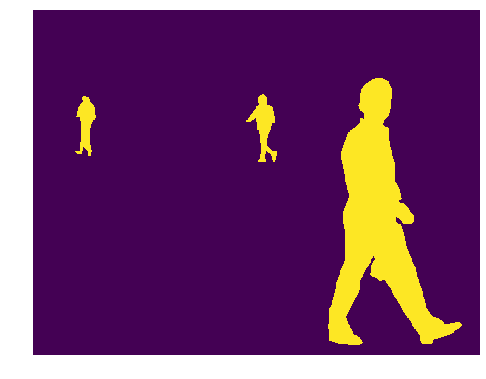

In [5]:
mask = (mask != 0)

plt.figure(figsize=(8,8))
plt.imshow(mask)
plt.axis('off')

## 3. Define DataGenerator 

In [6]:
class Pedestrian_Datagenerator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            mask = load_img(path, target_size=self.img_size, color_mode="grayscale")
            mask = np.array(mask)
            mask = mask!=0
            y[j] = np.expand_dims(mask, 2)
        return x/255, y

## 4. Split Data into Train / Test 

In [7]:
# Collect all paths

input_dir = "PennFudanPed/PNGImages/"
target_dir = "PennFudanPed/PedMasks/"


input_img_paths = sorted(glob.glob(input_dir + '*.png'))
target_img_paths = sorted(glob.glob(target_dir + '*.png'))

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 170
PennFudanPed/PNGImages/FudanPed00001.png | PennFudanPed/PedMasks/FudanPed00001_mask.png
PennFudanPed/PNGImages/FudanPed00002.png | PennFudanPed/PedMasks/FudanPed00002_mask.png
PennFudanPed/PNGImages/FudanPed00003.png | PennFudanPed/PedMasks/FudanPed00003_mask.png
PennFudanPed/PNGImages/FudanPed00004.png | PennFudanPed/PedMasks/FudanPed00004_mask.png
PennFudanPed/PNGImages/FudanPed00005.png | PennFudanPed/PedMasks/FudanPed00005_mask.png
PennFudanPed/PNGImages/FudanPed00006.png | PennFudanPed/PedMasks/FudanPed00006_mask.png
PennFudanPed/PNGImages/FudanPed00007.png | PennFudanPed/PedMasks/FudanPed00007_mask.png
PennFudanPed/PNGImages/FudanPed00008.png | PennFudanPed/PedMasks/FudanPed00008_mask.png
PennFudanPed/PNGImages/FudanPed00009.png | PennFudanPed/PedMasks/FudanPed00009_mask.png
PennFudanPed/PNGImages/FudanPed00010.png | PennFudanPed/PedMasks/FudanPed00010_mask.png


In [8]:
# Split into Train / Validation
val_samples = 20
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

print(f'Train set size: {len(train_input_img_paths)} \nValidation set size: {len(val_input_img_paths)}')

Train set size: 150 
Validation set size: 20


In [9]:
# Instantiate data generators

img_size = (160, 160)
batch_size = 4

train_gen = Pedestrian_Datagenerator(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = Pedestrian_Datagenerator(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## 5. Define Model 

In [10]:
def unet(img_size):
    inputs = Input(shape=img_size + (3,))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)


    up4 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (4,4))(pool3))
    merge4 = concatenate([conv2,up4], axis = 3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge4)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv4)

    up5 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv1,up5], axis = 3)
    conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge5)
    conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv5)
    conv5 = Conv2D(2, 3, activation = 'relu', padding = 'same')(conv5)
    conv6 = Conv2D(1, 1, activation = 'sigmoid')(conv5)

    model = keras.Model(inputs = inputs, outputs = conv6)

    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = unet(img_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 80, 80, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## 6. Compile and Train

In [11]:
model.compile(optimizer="adam", loss="binary_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("pedestrian_segmentation.h5", save_best_only=True)
]

In [12]:
# Train the model, doing validation at the end of each epoch.
epochs = 40
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 37 steps, validate for 5 steps
Epoch 1/40
37/37 [==============================] - 5s 135ms/step - loss: 0.4832 - val_loss: 0.3975
Epoch 2/40
37/37 [==============================] - 2s 57ms/step - loss: 0.3817 - val_loss: 0.3238
Epoch 3/40
37/37 [==============================] - 2s 58ms/step - loss: 0.3329 - val_loss: 0.3231
Epoch 4/40
37/37 [==============================] - 2s 58ms/step - loss: 0.3025 - val_loss: 0.2947
Epoch 5/40
37/37 [==============================] - 2s 58ms/step - loss: 0.2864 - val_loss: 0.2665
Epoch 6/40
37/37 [==============================] - 2s 55ms/step - loss: 0.2855 - val_loss: 0.2744
Epoch 7/40
37/37 [==============================] - 2s 58ms/step - loss: 0.2759 - val_loss: 0.2628
Epoch 8/40
37/37 [==============================] - 2s 58ms/step - loss: 0.2719 - val_loss: 0.2387
Epoch 9/40
37/37 [==============================] - 2s 57ms/step - loss: 0.2609 - val_loss: 0.2262
Epoch 10/40
37/37

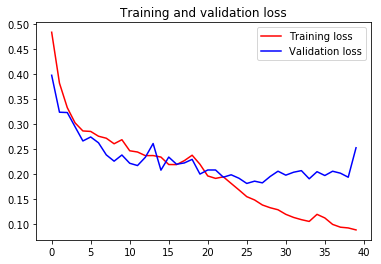

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 6. Inference

#### a) On Train Set 

In [14]:
train_gen = Pedestrian_Datagenerator(1, img_size, train_input_img_paths, train_target_img_paths)
train_preds = model.predict(train_gen)

		Image 				 Ground Truth 				 Prediction


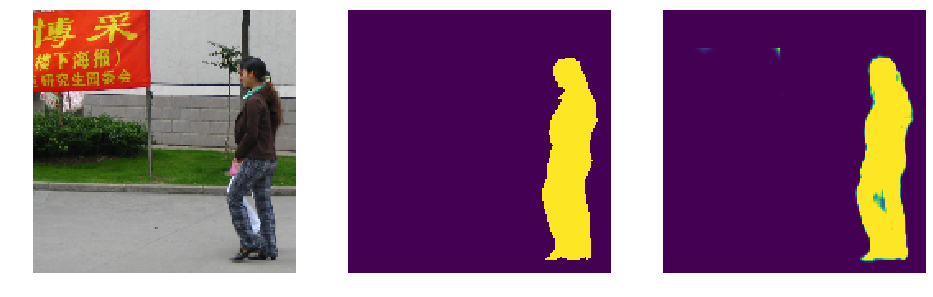

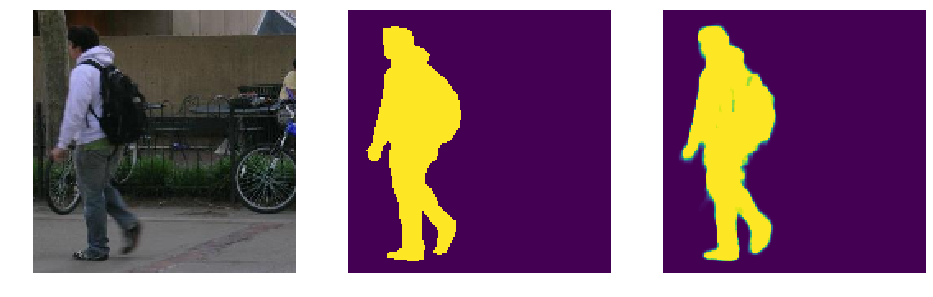

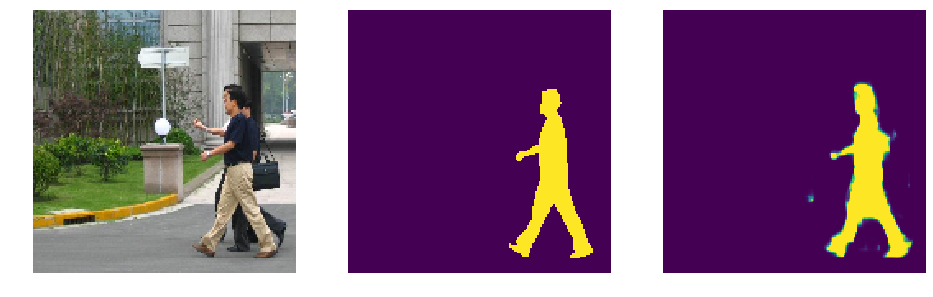

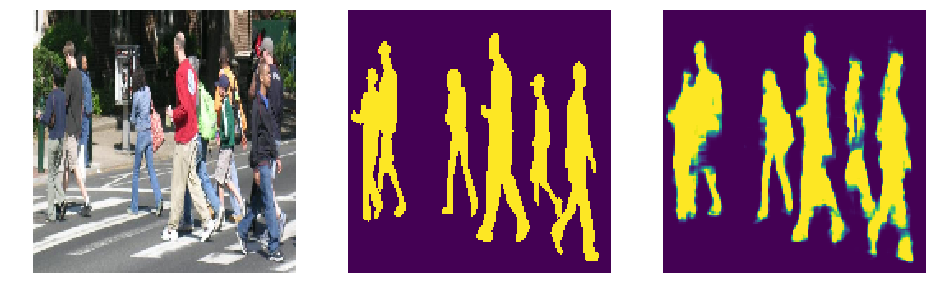

In [15]:
samples = 4
idxs = np.arange(0,20); random.Random(42).shuffle(idxs); idxs = idxs[:4]


print('\t\tImage \t\t\t\t Ground Truth \t\t\t\t Prediction')
for i in np.arange(samples):
    idx = idxs[i]
    x, y = train_gen[idx]
    pred = train_preds[idx]
    
    plt.figure(figsize=(16,16))
    
    # Image
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(x[0])
    ax1.axis('off')
    #ax1.set_title('Image')
    
    # Mask
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(y.squeeze())
    ax2.axis('off')
    #ax2.set_title('Ground Truth')
    
    # Pred
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(pred.squeeze())
    ax3.axis('off')
    #ax3.set_title('Prediction')

#### b) On Validation Set 

In [16]:
val_gen = Pedestrian_Datagenerator(1, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

		Image 				 Ground Truth 				 Prediction


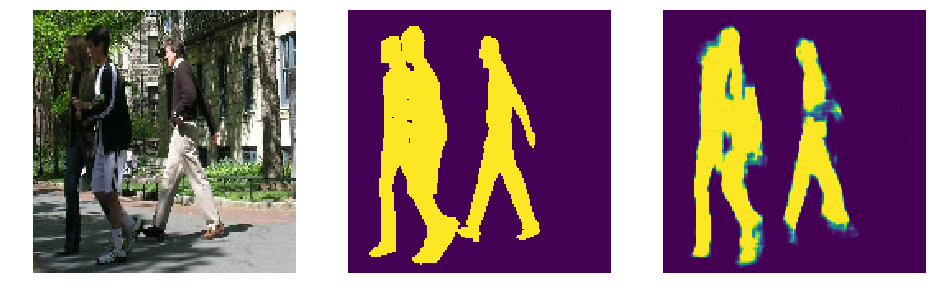

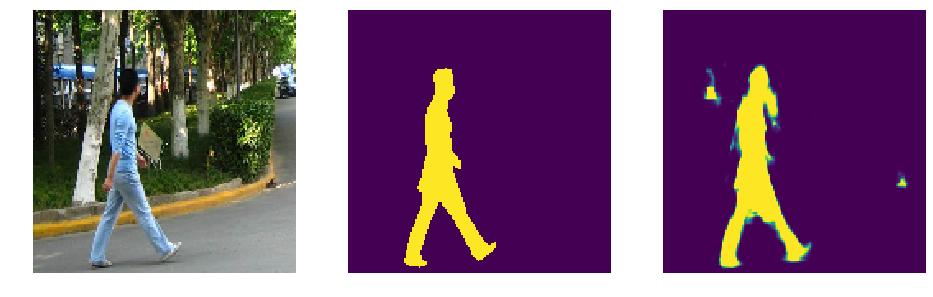

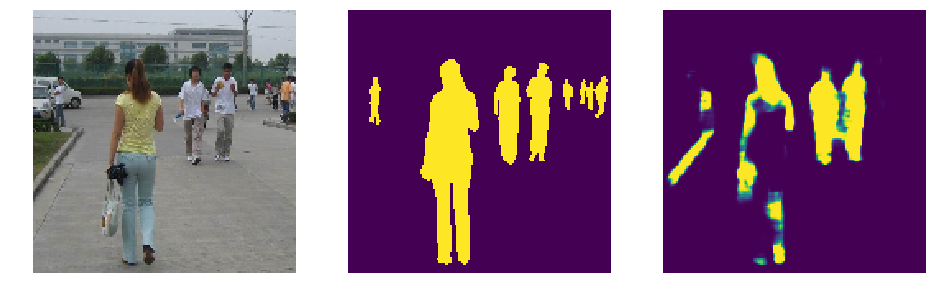

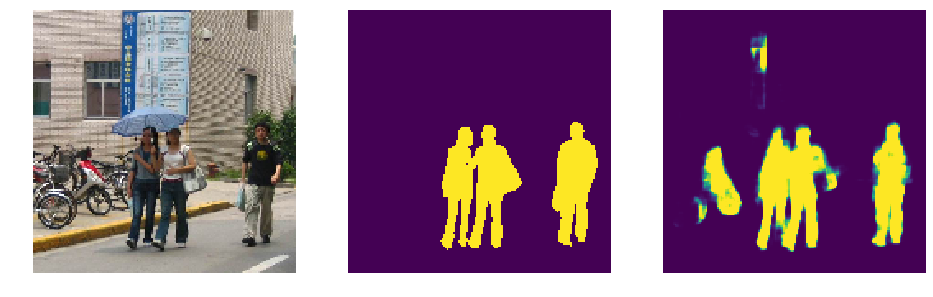

In [17]:
samples = 4
idxs = np.arange(0,20); random.Random(42).shuffle(idxs); idxs = idxs[:4]


print('\t\tImage \t\t\t\t Ground Truth \t\t\t\t Prediction')
for i in np.arange(samples):
    idx = idxs[i]
    x, y = val_gen[idx]
    pred = val_preds[idx]
    
    plt.figure(figsize=(16,16))
    
    # Image
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(x[0])
    ax1.axis('off')
    #ax1.set_title('Image')
    
    # Mask
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(y.squeeze())
    ax2.axis('off')
    #ax2.set_title('Ground Truth')
    
    # Pred
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(pred.squeeze())
    ax3.axis('off')
    #ax3.set_title('Prediction')